## EIA testing


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytest
from decimal import Decimal
from pudl import init, analysis, settings, output
import pudl.constants as pc
import pudl.output.pudltabl

%matplotlib inline

In [3]:
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (6,5)
matplotlib.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
pd.options.mode.use_inf_as_na = False

## Output objects vs. modules...
 * In this next cell what you've done (I think inadvertently) is set `pudl_out_eia` equal to the `eia923` output *module* and then later you're calling functions that reside within that module.
 * My *guess* is what you meant to do is create a `PudlTabl` output object, and then use it to compile the tables for testing.
 * The latter is what the testing framework is expecting -- several different `PudlTabl` output objects are created by the output fixtures, at a variety of frequencies (None, monthly, annual).
 * If the test functions take one of these output objects as their argument, then once the table is calculated, it can be re-used in a variety of contexts, which will make the tests run much faster than if the same compliation of data has to be read out of the database repeatedly.

In [5]:
pudl_out_eia = pudl.output.eia923 # Path to EIA923 tables, for use in test_frc_eia923 function

## EIA 923 Fuel Receipts and Costs

In [6]:
frc_eia923 = pudl_out_eia.fuel_receipts_costs_eia923(freq=None) # Data frame of EIA923 FRC table

## Fixed numbers vs. percentiles
 * Rather than just picking a single number it might be more descriptive to have a precentile and a number, so we're conveying information about how stringent the test we're applying is.
 * You can see my one-off version of this (which should be generalized) in the EIA860 plant ownership tests.

In [37]:
max_unit_fuel_cost = 35 # In $/mmbtu, threshold for identifying outlier records
max_unit_heat_content = 32 # In mmbtu/fuel unit, threshold for identifying outlier records

## Comments:
### Reusability:
 * Right now you've defined the test function in both the notebook and the python test module. It should only be defined in the module, and imported into the notebook, so they're always running exactly the same code.
 * What's the generalization of the test you're doing here? It really doesn't have anything to do with frc_eia923 in particular -- you're checking the values in a column to see whether they lie within some acceptable range, or that at least the vast majority of the values lie within an acceptable range.
 * This could be re-written as a much more general data validation test that could be used on many columns in many different output dataframes. What would reasonable parameters look like for that? A value, a flag indicating whether it's an upper or lower bound, and a percentile indicating what proportion of values is acceptable above it (for an upper bound) or below it (for a lower bound)
 * For the purpose of re-using the test function with minimal overhead, we probably don't want to be re-calculating values in the tables to be tested, or re-pulling them from the DB once they've been read. This is what the output object fixtures do for us -- they let us keep one persistent object that stores all this information for re-use throughout the test session.
 
### String formatting:
 * I *think* you're using `Decimal` and `round()` here to do string formatting, and there's a much simpler way to do that. See the next cell...
 * `f-strings` allow you to embed the variable you want to print directly inside the string, and the stuff after the `:` in the {curly braces} that contain the string indicate how to format the variable. In this case `:.2%` says "Two digits after the decimal place, formatted as a percentage"
 * This is much more compact, and doesn't require you to change the value of the thing you're trying to output.
 * In non-percentage contexts, the number indicates the number after the decimal indicates the total number of significant digits


In [49]:
print(f"Look at all these sigfigs:  {np.pi}")
print(f"But now as a percentage:    {np.pi:.2%}")
print(f"Or just rounded down:       {np.pi:.2}")
print(f"How about 6 digits instead: {np.pi:.6}")

Look at all these sigfigs:  3.141592653589793
But now as a percentage:    314.16%
Or just rounded down:       3.1
How about 6 digits instead: 3.14159


In [8]:
# Function that approximates the test in pudl/scripts/test/validation/eia923_test.py
def test_frc_eia923(pudl_out_eia, max_unit_fuel_cost = max_unit_fuel_cost, 
                    max_unit_heat_content = max_unit_heat_content, freq=None):
    """
    Sanity checks for EIA 923 fuel costs and heat rates by unit.
    
    Args:
        max_unit_fuel_cost (int): The threshold for identifying 'fuel_cost_per_mmbtu' records that exceed
    
        freq (None or str): Temporal scale of records to evaluate. It must be one of the following:
            - None
            - 'MS'
            - 'YS'
            
    Returns print statement counting outlier records
    """
        
    # Verify the number of outliers for the fuel cost per mmbtu
    frc_eia923 = pudl_out_eia.fuel_receipts_costs_eia923(freq=freq)

    fuel_unit_outliers = len(frc_eia923.loc[(frc_eia923.fuel_cost_per_mmbtu > max_unit_fuel_cost) | 
                                        (frc_eia923.fuel_cost_per_mmbtu < 0)]) 
    
    decimal = Decimal((fuel_unit_outliers/(len(frc_eia923)))*100)
    proportion = round(decimal, 2)
                    
    print (f"{fuel_unit_outliers} records, {proportion}% of the total, have outlier fuel unit costs")
    
    heat_content_outliers = len(frc_eia923.loc[(frc_eia923.heat_content_mmbtu_per_unit > max_unit_heat_content) |
                                           (frc_eia923.heat_content_mmbtu_per_unit < 0)])

    decimal = Decimal((heat_content_outliers/(len(frc_eia923)))*100)
    proportion = round(decimal, 2)

    print (f"{heat_content_outliers} records, {proportion}% of the total, have outlier heat unit values")


In [39]:
# Run the function
test_frc_eia923(pudl_out_eia)

1047 records, 0.41% of the total, have outlier fuel unit costs
0 records, 0.00% of the total, have outlier heat unit values


In [40]:
test_frc_eia923(pudl_out_eia, freq='MS')

603 records, 0.56% of the total, have outlier fuel unit costs
0 records, 0.00% of the total, have outlier heat unit values


In [41]:
test_frc_eia923(pudl_out_eia, freq='YS')

16 records, 0.15% of the total, have outlier fuel unit costs
0 records, 0.00% of the total, have outlier heat unit values


In [42]:
# Plot the non-outlier values to see distribution
plot_var = frc_eia923.fuel_cost_per_mmbtu.loc[(frc_eia923.fuel_cost_per_mmbtu < max_unit_fuel_cost) & 
                          (frc_eia923.fuel_cost_per_mmbtu > 0)]

## Breaking it out by fuel
 * It looks like there are a few different humps in here, which isn't too surprising, since there are at least 3 major fuels being used (coal, gas, and petroleum).
 * Each of these fuels will have different reasonable for the variable that you're testing.  Coal at \$20/mmBTU is completely wrong, just like gas at \$100/mmBTU would be totally wrong.
 * This means that in addiiton to choosing threshold values / percentiles to specify a reasonable test, we may also need to specify a mask / filter for the table, associated with those values / percentiles, so that we're applying tests only to the rows for which they are appropriate.

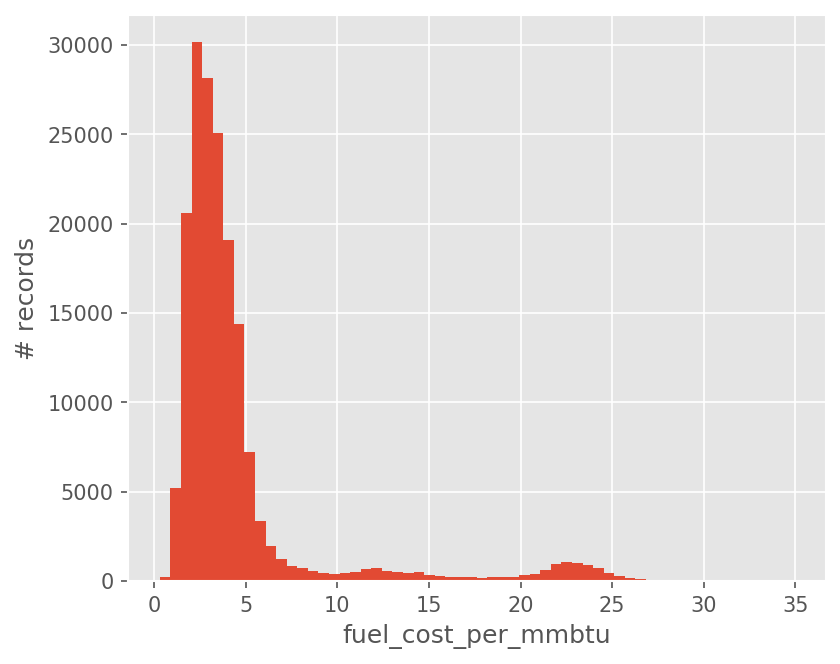

In [13]:
plt.hist(plot_var, bins=60)
plt.ylabel('# records')
plt.xlabel(plot_var.name);

In [44]:
# Plot the non-outlier values to see distribution
plot_var = frc_eia923.heat_content_mmbtu_per_unit[(frc_eia923.heat_content_mmbtu_per_unit <=  max_unit_heat_content) & 
                         (frc_eia923.heat_content_mmbtu_per_unit >=0)]

## Partitioning Part II
 * As in the above, there are 4 pretty clear domains to test here, and in this case there are two variables changing. Going from left to right I suspect these are the type of fuel (gas, petroleum, soft coal, hard coal) and what the unit of measure is for that fuel (mcf, gallons, tons, tons). Each of those subsets will have their own distribution of reasonable values that we should check against.

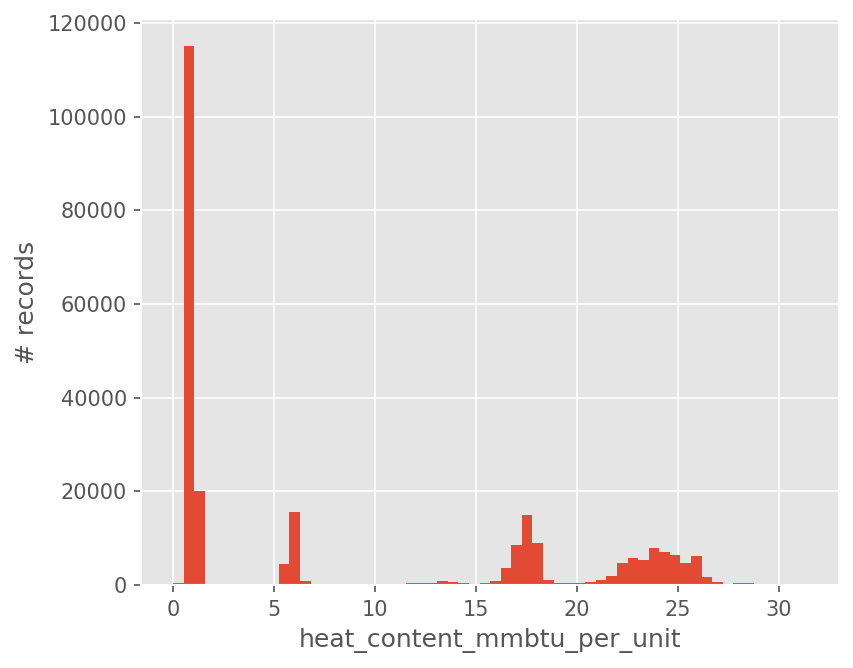

In [45]:
plt.hist(plot_var, bins=60)
plt.ylabel('# records')
plt.xlabel(plot_var.name);